<a href="https://colab.research.google.com/github/glukonatic/III/blob/master/16_Light%2BPro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание к занятию №16 "Генетические алгоритмы для обучения нейронных сетей"
## студента Университета искусственного интеллекта
## Наговицына Антона Михайловича
### Поток PRO НС - июль 2020 (основной тариф).

Части Лайт + Про

<img src="https://proza.ru/photos/glukonatic.jpg" alt="Фото Антон Наговицын" width="10%">

# Light

**ЗАДАНИЕ:**

Перепишите создание свёрточной сети с помощью ГА полностью своими руками

Можно взять готовыми некоторые сложные функции

Можно сделать другой формат свёрточной сети, не такой же, как в ноутбуке

Можно подсматривать в базовый ноутбук, но не копировать код напрямую


In [ ]:
#@title Доустановка библиотек

!pip install PrettyTable
!pip install colorama

In [ ]:
#@title Загружаем библиотеки

import pandas as pd 
import matplotlib.pyplot as plt 
from tensorflow.keras import utils 
import numpy as np 
from keras.optimizers import Adam 
from keras.models import Sequential, Model 
from keras.layers import concatenate,Reshape, Input,Conv2DTranspose, Lambda
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.layers import Conv1D, Conv2D, LSTM, MaxPooling1D, Activation
from keras.layers import GlobalMaxPooling1D, UpSampling1D
from keras.losses import MAE
from google.colab import files 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from keras.preprocessing.sequence import TimeseriesGenerator 
import keras.backend as K
import random as random 
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image 
import time
from tensorflow.keras.utils import plot_model
import seaborn as sns
sns.set_style('darkgrid')
from prettytable import PrettyTable
from progressbar import ProgressBar
from colorama import Fore, Back, Style
%matplotlib inline

In [ ]:
#@title Подключаем гуглдрайв

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Подготовка данных

base_data = pd.read_csv('/content/drive/MyDrive/III/16/traff.csv',header=None)
data = base_data.iloc[:,1]
data = np.array(data)
for i in range(len(data)):
  data[i] = float(data[i].replace(',',''))

xLen = 60     
valLen = 300 
trainLen = data.shape[0]-valLen 

Train,Test = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen+xLen+2:],(-1,1))
Scaler = MinMaxScaler()
Scaler.fit(Train)
Train = Scaler.transform(Train)
Test = Scaler.transform(Test)

trainDataGen = TimeseriesGenerator(Train, Train, length=xLen, sampling_rate=1, batch_size=20)
testDataGen = TimeseriesGenerator(Test, Test, length=xLen, sampling_rate=1, batch_size=20)

DataGen = TimeseriesGenerator(Test, Test, length=xLen, sampling_rate=1, batch_size=len(Test))

xVal = []
yVal = []

for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

## Подбор линейной архитектуры

In [ ]:
#@title Функции для выполнения ДЗ

def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(figsize=(18,10))
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
def correlate(a, b):
  ma = a.mean() 
  mb = b.mean()
  mab = (a*b).mean() 
  sa = a.std() 
  sb = b.std() 
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf = True, returnData = False):
  for ch in channels:
    corr = [] 
    yLen = yValUnscaled.shape[0] 

    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] 

    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    if showGraf:
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

  if showGraf: 
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if returnData:
    return corr, own_corr
    
def createConvNet(net):

  model = Sequential()
  
  makeFirstNormalization = net[0]
  firstConvSize = 2 ** net[1]
  firstConvKernel = net[2]
  activation0 = net[3]
  makeMaxPooling0 = net[4]
  maxPoolingSize0 = net[5]

  makeSecondConv = net[6]
  secondConvSize = 2 ** net[7]
  secondConvKernel = net[8]
  makeMaxPooling1 = net[9]
  maxPoolingSize1 = net[10]
  activation1 = net[11]

  makeThirdConv = net[12]
  thirdConvSize = 2 ** net[13]
  thirdConvKernel = net[14]
  makeMaxPooling2 = net[15]
  maxPoolingSize2 = net[16]
  activation2 = net[17]

  activation3 = net[18]
  activation4 = net[19]

  makeSecondNormalization = net[20]
  denseSize = 2 ** net[21]

  activation_list = ['linear','relu','tanh','softmax','sigmoid'] 

  if (makeFirstNormalization):
    model.add(BatchNormalization(input_shape=(xLen, 1))) 
    model.add(Conv1D(firstConvSize, firstConvKernel, activation=activation_list[activation0], padding='same')) 
  else:
    model.add(Conv1D(firstConvSize, firstConvKernel, input_shape=(xLen, 1), activation=activation_list[activation0], padding='same')) 

  if makeMaxPooling0: 
    model.add(MaxPooling1D(maxPoolingSize0))

  if (makeSecondConv):
    model.add(Conv1D(secondConvSize, secondConvKernel, activation=activation_list[activation1], padding='same')) 
    
    if (makeMaxPooling1):
      model.add(MaxPooling1D(pool_size=maxPoolingSize1)) 

  if (makeThirdConv):
    model.add(Conv1D(thirdConvSize, thirdConvKernel, activation=activation_list[activation2], padding='same')) 

    if (makeMaxPooling2): 
      model.add(MaxPooling1D(pool_size=maxPoolingSize2)) 
          
  if (makeSecondNormalization): 
    model.add(BatchNormalization())
  
  model.add(Flatten())
  model.add(Dense(denseSize, activation=activation_list[activation3]))
  model.add(Dense(1, activation=activation_list[activation4]))
  
  return model

'''
  Функция вычисления результата работы сети
'''

def evaluateNet(net, ep, verb):
  val = 0
  time.time()
  model = createConvNet(net) 
  model.compile(optimizer=Adam(lr=1e-4),
                  loss='mse')

  history = model.fit(trainDataGen, epochs=5, verbose=verb, validation_data=testDataGen)
    
  val = history.history["val_loss"][-1]
  
  return val, model

'''
  Функция создания списка случайных параметров
'''
def createRandomNet():
  net = []
  net.append(random.randint(0,1))
  net.append(random.randint(3,6))
  net.append(random.randint(3,7))
  net.append(random.randint(0,4))
  net.append(random.randint(0,1))
  net.append(random.randint(2,5))

  net.append(random.randint(0,1))
  net.append(random.randint(3,6))
  net.append(random.randint(3,7))
  net.append(random.randint(0,1)) 
  net.append(random.randint(2,5)) 
  net.append(random.randint(0,4))

  net.append(random.randint(0,1))
  net.append(random.randint(3,6))
  net.append(random.randint(3,7))
  net.append(random.randint(0,1))
  net.append(random.randint(2,5))
  net.append(random.randint(0,4))

  net.append(random.randint(0,4))
  net.append(random.randint(0,2))

  net.append(random.randint(0,1))
  net.append(random.randint(3,6))
  
  return net

In [ ]:
#@title Создаем популяцию агентов-ботов, запускаем генетический алгоритм для нейронки

n = 20
nsurv = 10
nnew = n - nsurv
l = 22
epohs = 10
mut = 0.09

popul = []
val = []

for i in range(n):
  popul.append(createRandomNet())

for it in range(epohs):
  val = []
  curr_time = time.time()
  for i in range(n):
    bot = popul[i]
    f, model_sum = evaluateNet(bot, 3, 0)
    val.append(f)
  
  sval = sorted(val, reverse=0)
  newpopul = []

  for i in range(nsurv):
    index = val.index(sval[i])
    newpopul.append(popul[index])
    
  for inew in range(nnew): 
    indexp1 = random.randint(0,nsurv-1)
    indexp2 = random.randint(0,nsurv-1)
    botp1 = newpopul[indexp1]
    botp2 = newpopul[indexp2]
    newbot = []
    net4Mut = createRandomNet()

    for j in range(l):
      x = 0      
      pindex = random.random()

      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]
      
      if (random.random() < mut):
        x = net4Mut[j]
        
      newbot.append(x)
    newpopul.append(newbot)

  popul = newpopul

100% (200 of 200) |######################| Elapsed Time: 0:07:34 Time:  0:07:34


In [ ]:
#@title Геномы лучших ботов по эпохам

header = ["Входной слой","Первый скрытый слой","Второй скрытый слой","Третий скрытый слой"]
table = PrettyTable(header,title='Легенда')

row1 = """0 - делаем ли нормализацию
1 - размер первого свёрточного слоя
2 - ядро первого свёрточного слоя
3 - функция активации первого слоя
4 - делаем ли MaxPooling0
5 - размер MaxPooling0"""

row2 = """6 - Делаем ли второй сверточный слой
7 - размер второго сверточного слоя
8 - ядро второго сверточного слоя
9 - делаем ли MaxPooling1
10 - размер MaxPooling1
11 - функция активации"""

row3 = """12 - Делаем ли третий сверточный слой
13 - размер третьего сверточного слоя
14 - ядро третьего сверточного слоя
15 - делаем ли MaxPooling2
16 - размер MaxPooling2
17 - функция активации"""

row4 = """20 - делаем ли нормализацию
21 - размер полносвязного слоя"""

table.add_row([row1,row2,row3,row4])
print(table)

print("""18 - функция активации предпоследнего слоя
19 - функция активации выходного слоя""")

header = []
header.append('№ ')
header.extend(list(np.arange(22)))
table = PrettyTable(header,title='Результаты работы генетического алгоритма. Строка - бот, столбец - параметр.')

for i, bot in enumerate(popul):
  row = []
  row.append(i+1)
  row.extend(bot)
  table.add_row(row)
print(table)

+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                       Легенда                                                                       |
+-------------------------------------+--------------------------------------+---------------------------------------+--------------------------------+
|             Входной слой            |         Первый скрытый слой          |          Второй скрытый слой          |      Третий скрытый слой       |
+-------------------------------------+--------------------------------------+---------------------------------------+--------------------------------+
|      0 - делаем ли нормализацию     | 6 - Делаем ли второй сверточный слой | 12 - Делаем ли третий сверточный слой |  20 - делаем ли нормализацию   |
| 1 - размер первого свёрточного слоя | 7 - размер второго сверточного слоя  | 13 - разм

Model: "sequential_721"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1409 (Conv1D)         (None, 60, 64)            384       
_________________________________________________________________
conv1d_1410 (Conv1D)         (None, 60, 64)            12352     
_________________________________________________________________
flatten_719 (Flatten)        (None, 3840)              0         
_________________________________________________________________
dense_1438 (Dense)           (None, 8)                 30728     
_________________________________________________________________
dense_1439 (Dense)           (None, 1)                 9         
Total params: 43,473
Trainable params: 43,473
Non-trainable params: 0
_________________________________________________________________


Нарисуем блок-схему нашей модели




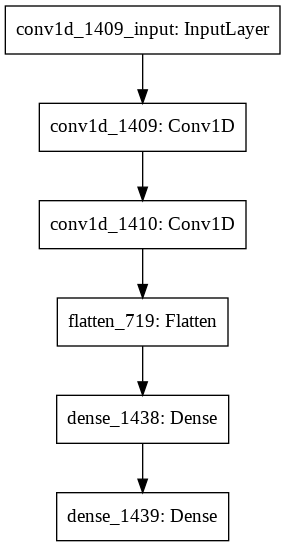

In [ ]:
#@title Создаем модель на основании показаний лучшего бота в популяции. Смотрим харастеристики

model = createConvNet(popul[0])
model.summary()
print(Fore.WHITE + Back.CYAN + '\n\nНарисуем блок-схему нашей модели\n')
print(Style.RESET_ALL)
plot_model(model)

In [ ]:
#@title Комипилируем и обучаем

model.compile(optimizer=Adam(lr=1e-4), loss='mse')

history = model.fit_generator(trainDataGen, epochs=50, validation_data=testDataGen)

Epoch 1/50
37/37 [==============================] - 0s 7ms/step - loss: 0.0313 - val_loss: 0.0171
Epoch 2/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0085 - val_loss: 0.0120
Epoch 3/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0078 - val_loss: 0.0142
Epoch 4/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 5/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0064
Epoch 6/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0056 - val_loss: 0.0076
Epoch 7/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 0.0060
Epoch 8/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0081
Epoch 9/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 10/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0079
Epoch 11/50
37/37 [

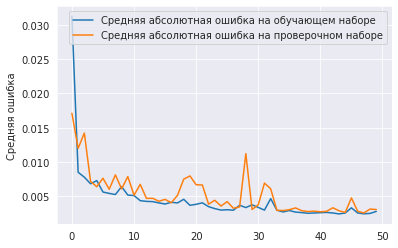

In [ ]:
#@title Выводим графики ошибки на обучающем и проверочтном наборе

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

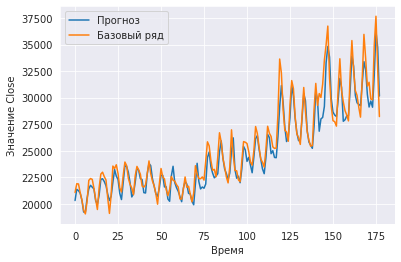

In [ ]:
#@title Прогнозируем данные текущей сетью

(predVal, yValUnscaled) = getPred(model, xVal[0], yVal[0], Scaler)
showPredict(0, 400, 0, predVal, yValUnscaled)

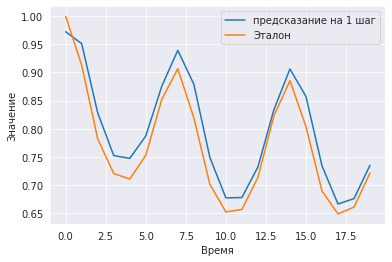

In [ ]:
#@title Отображаем корреляцию

autoCorr([0], 20, predVal, yValUnscaled)

Epoch 1/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0277 - val_loss: 0.0266
Epoch 2/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0150
Epoch 3/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0125 - val_loss: 0.0197
Epoch 4/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0082 - val_loss: 0.0087
Epoch 5/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0084 - val_loss: 0.0108
Epoch 6/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0070 - val_loss: 0.0106
Epoch 7/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0105
Epoch 8/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0065
Epoch 9/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0056 - val_loss: 0.0108
Epoch 10/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0088
Epoch 11/50
37/37 [

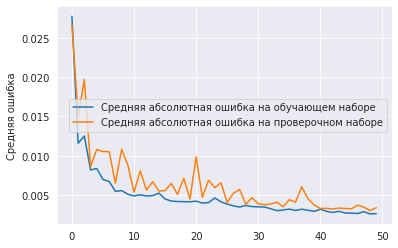

In [ ]:
#@title Вручную соберем сетку, обучаем, выводим графики ошибки

modelC = Sequential()
modelC.add(Conv1D(64, 5, input_shape=(xLen, 1), activation='linear', padding='same')) 
modelC.add(Conv1D(32, 3, activation='linear', padding='same')) 
modelC.add(Flatten())
modelC.add(Dense(8, activation='linear'))
modelC.add(Dense(1, activation='relu'))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelC.fit_generator(trainDataGen, epochs=50, verbose=1, validation_data=testDataGen)

plt.plot(history.history['loss'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

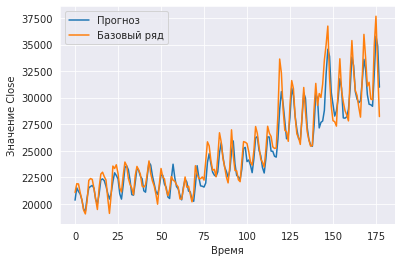

In [ ]:
#@title Прогнозируем данные текущей сетью, выводим результат

currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler)
showPredict(0, 400, 0, predVal, yValUnscaled)

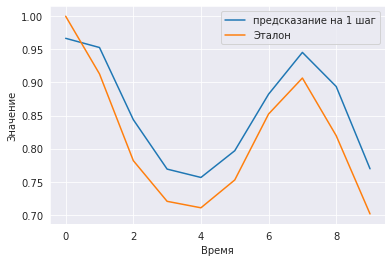

In [ ]:
#@title Отображаем корреляцию

autoCorr([0], 10, predVal, yValUnscaled)

## Подбор нелинейной архитектуры



Блок 1
*   0 - делаем ли нормализацию
*   1 - размер MaxPooling для всех слоев

*   2 - размер первого свёрточного слоя
*   3 - ядро первого свёрточного слоя
*   4 - функция активации первого слоя

Блок 2
*   5 - делаем ли второй свёрточный слой
*   6 - размер второго свёрточного слоя
*   7 - ядро второго свёрточного слоя
*   8 - делаем ли MaxPooling
*   9 - функция активации второго слоя 

Блок 3
*   10 - делаем ли второй свёрточный слой
*   11 - размер второго свёрточного слоя
*   12 - ядро второго свёрточного слоя
*   13 - делаем ли MaxPooling
*   14 - функция активации второго слоя 

Блок 4
*   15 - делаем ли второй свёрточный слой
*   16 - размер второго свёрточного слоя
*   17 - ядро второго свёрточного слоя
*   18 - делаем ли MaxPooling
*   19 - функция активации второго слоя 

Блок 5
*   20 - делаем ли второй свёрточный слой
*   21 - размер второго свёрточного слоя
*   22 - ядро второго свёрточного слоя
*   23 - делаем ли MaxPooling
*   24 - функция активации второго слоя 

Блок 6
*   25 - делаем ли нормализацию перед полносвязным слоем
*   26 - делаем ли полносвязный слой
*   27 - размер полносвязного слоя

In [ ]:
#@title Функции для создания нелинейной модели

def createConvNet(net):
  
  makeFirstNormalization = net[0] 
  maxPoolKernel = net[1]
  firstConvSize = 2 ** net[2]
  firstConvKernel = net[3]
  activation1 = net[4]
  makeConv2 = net[5]
  secondConvSize = 2 ** net[6]
  secondConvKernel = net[7]
  makePool2 = net[8]
  activation2 = net[9]
  makeConv3 = net[10]
  thirdConvSize = 2 ** net[11]
  thirdConvKernel = net[12]
  makePool3 = net[13]
  activation3 = net[14]
  makeConv4 = net[15]
  fourthConvSize = 2 ** net[16]
  fourthConvKernel = net[17]
  makePool4 = net[18]
  activation4 = net[19]
  makeConv5 = net[20]
  fifthConvSize = 2 ** net[21]
  fifthConvKernel = net[22]
  makePool5 = net[23]
  activation5 = net[24]
  makeDense = net[25]
  denseSize = 2 ** net[26]
  activation6 = net[27]

  shape = (xLen, 1)
  inputs = Input(shape)

  activation_list = ['linear','relu','tanh','softmax','sigmoid']

  if (makeFirstNormalization): 
    x = BatchNormalization()(inputs)
    x = Conv1D(firstConvSize,firstConvKernel, padding ='same')(x)
    x1 = Activation(activation_list[activation1])(x)
  else:
    x = Conv1D(firstConvSize,firstConvKernel, padding ='same')(inputs)
    x = Activation(activation_list[activation1])(x)

  list_to_concat = [inputs]

  for i in range(4):
    if net[5+5*i]!=0:
      x = Conv1D(net[6+5*i],net[7+5*i], padding ='same')(x)
      x = Activation(activation_list[net[5*i+4]])(x)

      if net[8+5*i]!=0:
        x = MaxPooling1D(maxPoolKernel)(x)
        list_to_concat.append(x)
      else:
        list_to_concat.append(x)

  for i in range(len(list_to_concat)):    
    if list_to_concat[i].shape != (None,0,1):
      list_to_concat[i] = Flatten()(list_to_concat[i]) 
    else:
      break

  if len(list_to_concat) != 1:
     fin = concatenate(list_to_concat)
  else:
    fin = x
    fin = Flatten()(fin)

  if makeDense!=0:
    fin = Dense(denseSize)(fin)
    fin = Activation(activation_list[activation6])(fin)

  fin = Dense(1)(fin)

  model = Model(inputs, fin) 
  return model

'''
  Функция вычисления резульата работы сети
'''
def evaluateNet(net, ep, verb):
  val = 0
  model = createConvNet(net)
  model.compile(optimizer=Adam(lr=1e-4), loss='mse')

  history = model.fit_generator(trainDataGen, epochs=5, verbose=verb, validation_data=testDataGen)
  (predVal, yValUnscaled) = getPred(model, xVal[0], yVal[0], Scaler)
  
  corr, own_corr = autoCorr([0], 5, predVal, yValUnscaled, showGraf = False, returnData = True)
  val = MAE(corr, own_corr).numpy() * history.history["val_loss"][-1] 

  return val, model 

'''
  Функция создания списка случайных параметров
'''
def createRandomNet():
  net = []
  net.append(random.randint(0,1)) 
  net.append(random.randint(2,3))
  net.append(random.randint(3,10))
  net.append(random.randint(3,7))
  net.append(random.randint(0,4))
  net.append(random.randint(0,1))
  net.append(random.randint(3,10))
  net.append(random.randint(3,7))
  net.append(random.randint(0,1))
  net.append(random.randint(0,4))
  net.append(random.randint(0,1))
  net.append(random.randint(3,10))
  net.append(random.randint(3,7))
  net.append(random.randint(0,1))
  net.append(random.randint(0,4))
  net.append(random.randint(0,1))
  net.append(random.randint(3,10))
  net.append(random.randint(3,7))
  net.append(random.randint(0,1))
  net.append(random.randint(0,4))
  net.append(random.randint(0,1))
  net.append(random.randint(3,10))
  net.append(random.randint(3,7))
  net.append(random.randint(0,1))
  net.append(random.randint(0,4))
  net.append(random.randint(0,1))
  net.append(random.randint(3,10))
  net.append(random.randint(0,4))
  return net

In [ ]:
#@title Рождение популяции, эволюция, получение лучших представителей популяции

n = 20 
nsurv = 7 
nnew = n - nsurv
l = 28
epohs = 9
mut = 0.4

popul = []
val = []

for i in range(n):
  popul.append(createRandomNet())
  
for it in range(epohs):
  val = []
  curr_time = time.time()
  for i in range(n):
    bot = popul[i]
    f,model_sum = evaluateNet(bot, 3, 0) 
    val.append(f)

  sval = sorted(val, reverse=0) 
  newpopul = []
  for i in range(nsurv):
    index = val.index(sval[i])
    newpopul.append(popul[index])
    
  for i in range(nnew):
    indexp1 = random.randint(0,nsurv-1)
    indexp2 = random.randint(0,nsurv-1)
    botp1 = newpopul[indexp1]
    botp2 = newpopul[indexp2]
    newbot = []
    net4Mut = createRandomNet()
    for j in range(l):
      x = 0      
      pindex = random.random()

      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]
      
      if (random.random() < mut):
        x = net4Mut[j]
        
      newbot.append(x)
    newpopul.append(newbot)
  popul = newpopul

In [ ]:
#@title Геномы лучших ботов по эпохам

# header = ["Входной слой","Первый скрытый слой","Второй скрытый слой","Третий скрытый слой"]
# table = PrettyTable(header,title='Легенда')

# row1 = """0 - делаем ли нормализацию
# 1 - размер первого свёрточного слоя
# 2 - ядро первого свёрточного слоя
# 3 - функция активации первого слоя
# 4 - делаем ли MaxPooling0
# 5 - размер MaxPooling0"""

# row2 = """6 - Делаем ли второй сверточный слой
# 7 - размер второго сверточного слоя
# 8 - ядро второго сверточного слоя
# 9 - делаем ли MaxPooling1
# 10 - размер MaxPooling1
# 11 - функция активации"""

# row3 = """12 - Делаем ли третий сверточный слой
# 13 - размер третьего сверточного слоя
# 14 - ядро третьего сверточного слоя
# 15 - делаем ли MaxPooling2
# 16 - размер MaxPooling2
# 17 - функция активации"""

# row4 = """20 - делаем ли нормализацию
# 21 - размер полносвязного слоя"""

# table.add_row([row1,row2,row3,row4])
# print(table)

# print("""18 - функция активации предпоследнего слоя
# 19 - функция активации выходного слоя""")

header = []
header.append('№ ')
header.extend(list(np.arange(28)))
table = PrettyTable(header,title='Результаты работы генетического алгоритма. Строка - бот, столбец - параметр.')

for i, bot in enumerate(popul):
  row = []
  row.append(i+1)
  row.extend(bot)
  table.add_row(row)
print(table)

+---------------------------------------------------------------------------------------------------------------------------------------+
|                              Результаты работы генетического алгоритма. Строка - бот, столбец - параметр.                             |
+----+---+---+---+---+---+---+----+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
| №  | 0 | 1 | 2 | 3 | 4 | 5 | 6  | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 25 | 26 | 27 |
+----+---+---+---+---+---+---+----+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
| 1  | 0 | 3 | 4 | 7 | 0 | 0 | 8  | 3 | 0 | 2 | 1  | 10 | 5  | 0  | 0  | 1  | 6  | 6  | 0  | 2  | 1  | 9  | 3  | 0  | 4  | 1  | 10 | 4  |
| 2  | 0 | 2 | 4 | 4 | 0 | 0 | 6  | 3 | 0 | 2 | 0  | 10 | 7  | 0  | 1  | 1  | 6  | 6  | 0  | 4  | 0  | 9  | 5  | 0  | 0  | 1  | 8  | 1  |
| 3  | 0 | 2 | 8 | 4 | 0 | 0 | 5  

In [ ]:
#@title Выводим суммари модели по лучшему боту в популяции

model = createConvNet(popul[0])
model.summary()

Model: "functional_361"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_181 (InputLayer)          [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_1876 (Conv1D)            (None, 60, 16)       128         input_181[0][0]                  
__________________________________________________________________________________________________
activation_589 (Activation)     (None, 60, 16)       0           conv1d_1876[0][0]                
__________________________________________________________________________________________________
conv1d_1877 (Conv1D)            (None, 60, 10)       810         activation_589[0][0]             
_____________________________________________________________________________________

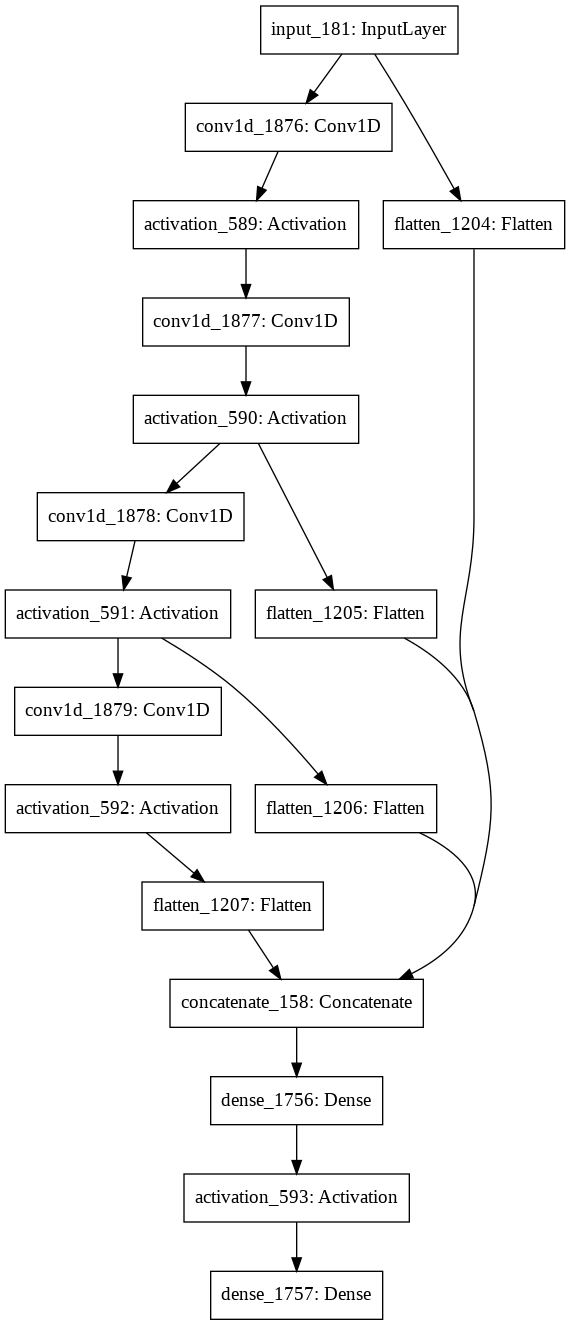

In [ ]:
#@title Выведем модель в виде графа

plot_model(model)

In [ ]:
#@title Комипилируем и обучаем

model.compile(optimizer=Adam(lr=1e-4), loss='mse')
history = model.fit_generator(trainDataGen, epochs=50, validation_data=testDataGen)

Epoch 1/50
37/37 [==============================] - 0s 9ms/step - loss: 0.0645 - val_loss: 0.0303
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0103 - val_loss: 0.0086
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0062
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0063 - val_loss: 0.0071
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0085
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0118
Epoch 10/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0075
Epoch 11/50
37/37 [

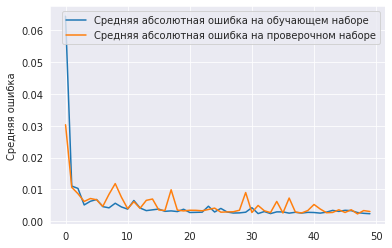

In [ ]:
#@title Выведем графики ошибки

plt.plot(history.history['loss'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

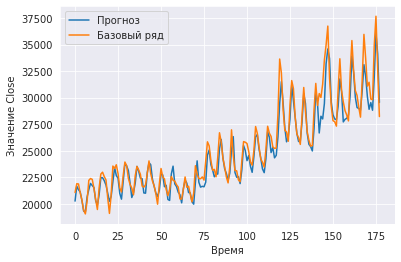

In [ ]:
#@title Прогнозируем данные текущей сетью

currModel = model
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler)
showPredict(0, 400, 0, predVal, yValUnscaled)

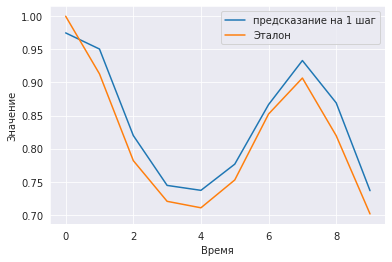

In [ ]:
#@title Отображаем корреляцию

autoCorr([0], 10, predVal, yValUnscaled)

# Pro 

Нарастите сложность свёрточной сети, которая генерируется

1. Сделайте возможность бота создать любую последовательность слоёв в любом количестве

2. Можно управлять вероятностью появления свёрточных слоёв, MaxPooling, BatchNormalization и Dropout (сделать разную вероятность)

3. Можно жёстко настроить появление Flatten и полносвязные слои только в конце

4. Полносвязные слои ГА также может генерить в любом количестве

Сделайте своими руками довольно мощную свёрточную сеть для предсказания трафика. 

Добейтесь, чтобы ГА сделал точность на проверочной выше, чем у вашей сети

Для скорости можно сократить количество эпох/увеличить скорость оптимизатора и т.д.


In [ ]:
#@title Доустановка библиотек

!pip install PrettyTable
!pip install colorama

In [ ]:
#@title Загружаем библиотеки

import pandas as pd 
import matplotlib.pyplot as plt 
from tensorflow.keras import utils 
import numpy as np 
from keras.optimizers import Adam 
from keras.models import Sequential, Model 
from keras.layers import concatenate,Reshape, Input,Conv2DTranspose, Lambda
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.layers import Conv1D, Conv2D, LSTM, MaxPooling1D, Activation
from keras.layers import GlobalMaxPooling1D, UpSampling1D
from keras.layers import AveragePooling1D, MaxPool1D
from keras.losses import MAE
from google.colab import files 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from keras.preprocessing.sequence import TimeseriesGenerator 
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
import random as random 
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image 
import time
from tensorflow.keras.utils import plot_model
import seaborn as sns
sns.set_style('darkgrid')
from prettytable import PrettyTable
from progressbar import ProgressBar
from colorama import Fore, Back, Style
%matplotlib inline

In [ ]:
#@title Подключаем гуглдрайв

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Подготовка данных

base_data = pd.read_csv('/content/drive/MyDrive/III/16/traff.csv',header=None)
data = base_data.iloc[:,1]
data = np.array(data)
for i in range(len(data)):
  data[i] = float(data[i].replace(',',''))

xLen = 60     
valLen = 300 
trainLen = data.shape[0]-valLen 

Train,Test = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen+xLen+2:],(-1,1))
Scaler = MinMaxScaler()
Scaler.fit(Train)
Train = Scaler.transform(Train)
Test = Scaler.transform(Test)

trainDataGen = TimeseriesGenerator(Train, Train, length=xLen, sampling_rate=1, batch_size=20)
testDataGen = TimeseriesGenerator(Test, Test, length=xLen, sampling_rate=1, batch_size=20)

DataGen = TimeseriesGenerator(Test, Test, length=xLen, sampling_rate=1, batch_size=len(Test))

xVal = []
yVal = []

for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

activation_list = ['linear','relu','tanh','softmax','sigmoid','elu','selu']

In [ ]:
#@title Функции для выполнения ДЗ

def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(figsize=(18,10))
  plt.plot(predVal[start:start+step, channel], label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
def correlate(a, b):
  ma = a.mean() 
  mb = b.mean()
  mab = (a*b).mean() 
  sa = a.std() 
  sb = b.std() 
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf = True, returnData = False):
  for ch in channels:
    corr = [] 
    yLen = yValUnscaled.shape[0] 

    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] 

    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    if showGraf:
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

  if showGraf: 
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if returnData:
    return corr, own_corr
    

'''
  Функция вычисления резульата работы сети
'''
def evaluateNet(net, ep, verb, p, b, d):
  val = 0
  # def createConvNet(bot, max_pooling_probability, avg_pooling_probability):

  model = createConvNet(net, p=p, b=b, d=d)

  callback = EarlyStopping(monitor='loss', patience=3)

  model.compile(optimizer=Adam(lr=1e-5), loss='mae')

  # history = model.fit_generator(trainDataGen, epochs=5, verbose=verb, validation_data=testDataGen, callbacks=[callback])
  history = model.fit_generator(trainDataGen, epochs=5, verbose=verb, validation_data=testDataGen)
  (predVal, yValUnscaled) = getPred(model, xVal[0], yVal[0], Scaler)
  
  corr, own_corr = autoCorr([0], 5, predVal, yValUnscaled, showGraf = False, returnData = True)
  val = MAE(corr, own_corr).numpy() * history.history["val_loss"][-1] 

  return val, model 

In [ ]:
#@title Функции для построения рандомной нейронки
#@markdown Число возможных параллельных веток нейронки
num_of_parallels=5  #@param {type: "number"}
#@markdown Число возможных повторений звеньев, из которых строится ветка 
num_of_repeats_sc=5 #@param {type: "number"}

def createRandomNet(num_of_parallels=num_of_parallels, 
                    num_of_repeats_sc=num_of_repeats_sc):
  '''
    Функция создания списка случайных параметров
  '''

  bot = []                                    # Инициализация бота

  bot.append(random.randint(3,10))            # [0] Нейронов первого сверточного слоя
  bot.append(random.randint(3,7))             # [1] Размер ядра первого сверточного слоя
  bot.append(random.randint(0,len(activation_list)-1))    # [2] Функция аткивации первого сверточного слоя

  bot.append(random.randint(0,num_of_parallels))    # [3] Количество параллельных цепей  
  for i in range(num_of_parallels):           # Для каждой параллельной цепи
    bot.append(random.randint(0,num_of_repeats_sc)) # [4...] Количество повторяемых звеньев

  for i in range(num_of_parallels):           # Для каждой параллельной цепи
    for j in range(num_of_repeats_sc):        # Создаем звено из слоев
      
      bot.append(2**random.randint(2,8))      # Число нейронов сверточного слоя
      bot.append(random.randint(3,8))         # Ядро свертки
      bot.append(random.randint(0,len(activation_list)-1))  # Функция активации светрочного слоя
      bot.append(random.randint(1,9)/10)      # Коэффициент слоя Dropout
      bot.append(random.choice([0,1]))        # Флаг, делаем или нет нормализацию
      bot.append(random.choice([0,1]))        # Флаг, делаем или нет функцию активации
      bot.append(random.choice([0,1]))        # Флаг, делаем или нет слой Dropout
      
      bot.append(random.choice([0,1]))        # Флаг, делаем или нет слой MaxPool1D
      bot.append(random.randint(3,8))         # Размер ядра слоя
      bot.append(random.randint(0,len(activation_list)-1))  # Функция активации светрочного слоя
      bot.append(random.randint(1,9)/10)      # Коэффициент слоя Dropout
      bot.append(random.choice([0,1]))        # Флаг, делаем или нет нормализацию
      bot.append(random.choice([0,1]))        # Флаг, делаем или нет функцию активации
      bot.append(random.choice([0,1]))        # Флаг, делаем или нет слой Dropout

      bot.append(random.choice([0,1]))        # Флаг, делаем или нет слой AveragePooling1D
      bot.append(random.randint(3,8))         # Размер ядра слоя
      bot.append(random.randint(0,len(activation_list)-1))  # Функция активации светрочного слоя
      bot.append(random.randint(1,9)/10)      # Коэффициент слоя Dropout
      bot.append(random.choice([0,1]))        # Флаг, делаем или нет нормализацию
      bot.append(random.choice([0,1]))        # Флаг, делаем или нет функцию активации
      bot.append(random.choice([0,1]))        # Флаг, делаем или нет слой Dropout

  bot.append(random.randint(0,1))             # Флаг, делаем или нет слой Dense
  bot.append(random.randint(3,10))            # Число нейронов слоя Dense
  bot.append(random.randint(0,len(activation_list)-1))     # Функция активации слоя Dense

  return bot

def layer_cell(layer, 
               normalization_flag, 
               inputs, 
               activation_flag, 
               activation, 
               dropout_flag,
               dropout_koef,
               normalization_probability,
               dropout_probability):
  """
  Конструктор слоя.
  Входные данные:
    layer - слой, который добавляем 
    normalization_flag - выполнять или не выполнять нормализацию входа (0 - нет, 1 - да)
    inputs - входной тензор
    activation_flag - выполнять или не выполнять активацию (0 - нет, 1 - да)
    activation - активационная функция
    dropout_flag - выполнять или не выполнять добавление слоя Dropout (0 - нет, 1 - да)
    dropout_koef - коэффициент слоя Dropout
  Функция возвращает результат обработки контруктором
  """
  if normalization_flag and random.random() > normalization_probability: 
    x = BatchNormalization()(inputs)
    x = layer(x)
  else:
    x = layer(inputs)

  if activation_flag:
    x = Activation(activation)(x)

  if dropout_flag and random.random() > dropout_probability: 
    x = Dropout(dropout_koef)(x)
  
  return x


def createConvNet(bot, p, b, d):
  
  shape = (xLen, 1)
  inputs = Input(shape)
  
  # Сверточный слой, на входе в нейронку
  layer = Conv1D(bot[0], bot[1], padding ='same')
  x = layer_cell(layer, 1, inputs, 1, activation_list[bot[2]], 0, 0.1, b, d)

  list_to_concat = []

  # Циклично создаем параллельные ветки
  for i in range(bot[3]):
    xp = x
    # Циклично создаем звенья цепи-ветки
    for j in range(bot[4+i]):
      # Поправка на число нецикличных параметров в боте
      k = 21*j + 21*i + num_of_parallels + 4
      # Создаем сверточный слой
      layer = Conv1D(bot[k+0],bot[k+1], padding ='same')
      xp = layer_cell(layer, bot[k+4], xp, bot[k+5], activation_list[bot[k+2]], bot[k+6], bot[k+3],b,d)
      # Если есть флаг создания слоя MaxPooling и размерность тензора позволяет
      if bot[k+7] and xp.shape[1] > bot[k+8] and random.random() < p:
        # то присоединяем слой MaxPooling
        layer = MaxPooling1D(bot[k+8], padding="valid")
        xp = layer_cell(layer, bot[k+11], xp, bot[k+12], activation_list[bot[k+9]], bot[k+13], bot[k+10],b,d)
      # Если есть флаг создания слоя AveragePooling и размерность тензора позволяет
      if bot[k+14] and xp.shape[1] > bot[k+15] and random.random() < 1 - p:
        # то присоединяем слой MaxPooling
        layer = AveragePooling1D(bot[k+15], padding="valid")
        xp = layer_cell(layer, bot[k+18], xp, bot[k+19], activation_list[bot[k+16]], bot[k+20], bot[k+17],b,d)
    # Если имеются параллельные ветки (даже пусть она одна) - добавляем в список
    if bot[3] > 0:
      list_to_concat.append(xp)

  if len(list_to_concat) != 1:
    for i in range(len(list_to_concat)):    
      if list_to_concat[i].shape != (None,0,1):
        list_to_concat[i] = Flatten()(list_to_concat[i]) 
      else:
        break

  if len(list_to_concat) == 0:
    fin = x
    fin = Flatten()(fin)
  elif len(list_to_concat) == 1:
    fin = xp
    fin = Flatten()(fin)
  elif len(list_to_concat) > 1:
    fin = concatenate(list_to_concat)

  if bot[-3]!=0:
    fin = Dense(bot[-2])(fin)
    fin = Activation(activation_list[bot[-1]])(fin)

  fin = Dense(1)(fin)

  model = Model(inputs, fin) 
  return model

In [ ]:
#@title Рождение популяции, эволюция, получение лучших представителей популяции

#@markdown Число ботов в популяции
n = 100 #@param {type: "number"}
#@markdown Число выживших
nsurv = 5 #@param {type: "number"}
#@markdown Число эпох эволюции популяции
epohs =  30#@param {type: "number"}
#@markdown Коэффициент мутации
mut = 0.1 #@param {type: "number"}
#@markdown Вероятность добавления слоёв MaxPooling/AveragePooling
p = 0.5 #@param {type: "number"}
#@markdown Вероятность добавления слоя BatchNormalization
b = 0.5 #@param {type: "number"}
#@markdown Вероятность добавления слоя Dropout
d = 0.5 #@param {type: "number"}


nnew = n - nsurv 

popul = []
val = []

for i in range(n):
  popul.append(createRandomNet())
  
for it in range(epohs):
  print("{}.. ".format(it))
  val = []
  curr_time = time.time()
  for i in range(n):
    bot = popul[i]
    f,model_sum = evaluateNet(bot, 3, 0, p, b, d) 
    val.append(f)

  sval = sorted(val, reverse=0) 
  newpopul = []
  for i in range(nsurv):
    index = val.index(sval[i])
    newpopul.append(popul[index])
    
  for i in range(nnew):
    indexp1 = random.randint(0,nsurv-1)
    indexp2 = random.randint(0,nsurv-1)
    botp1 = newpopul[indexp1]
    botp2 = newpopul[indexp2]
    newbot = []
    net4Mut = createRandomNet()
    for j in range(len(botp1)):
      x = 0      
      pindex = random.random()

      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]
      
      if (random.random() < mut):
        x = net4Mut[j]
        
      newbot.append(x)
    newpopul.append(newbot)
  popul = newpopul

0.. 
1.. 
2.. 
3.. 
4.. 
5.. 
6.. 
7.. 
8.. 
9.. 
10.. 
11.. 
12.. 
13.. 
14.. 
15.. 
16.. 
17.. 
18.. 
19.. 
20.. 
21.. 
22.. 
23.. 
24.. 
25.. 
26.. 
27.. 
28.. 
29.. 


In [ ]:
#@title Выводим суммари модели по лучшему боту в популяции

model = createConvNet(popul[0],p,b,d)
model.summary()

Model: "functional_9003"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4502 (InputLayer)         [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_31796 (Conv1D)           (None, 60, 8)        56          input_4502[0][0]                 
__________________________________________________________________________________________________
activation_25131 (Activation)   (None, 60, 8)        0           conv1d_31796[0][0]               
__________________________________________________________________________________________________
conv1d_31797 (Conv1D)           (None, 60, 32)       1824        activation_25131[0][0]           
____________________________________________________________________________________

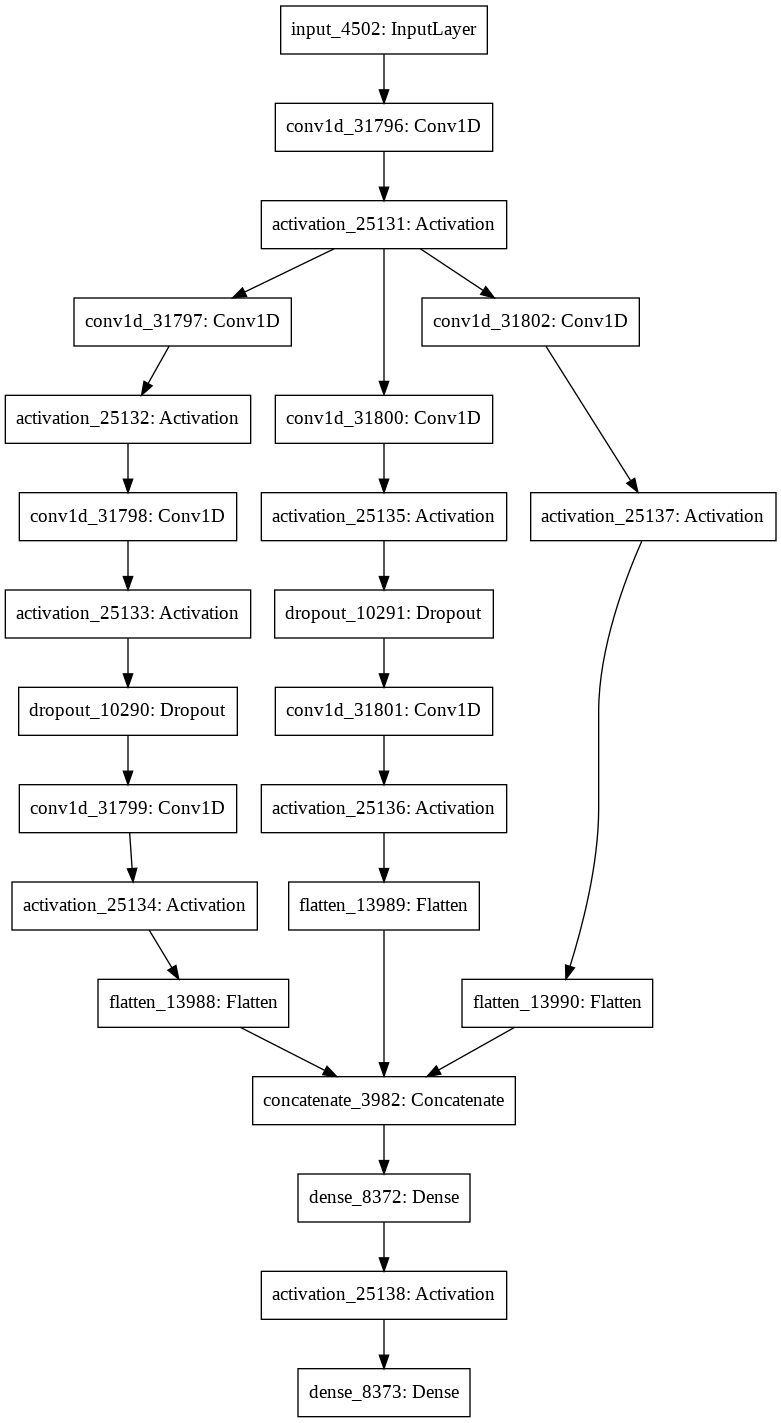

In [ ]:
#@title Выведем модель в виде графа

plot_model(model)

In [ ]:
#@title Комипилируем и обучаем

model.compile(optimizer=Adam(lr=1e-4), loss='mse')
history = model.fit_generator(trainDataGen, epochs=50, validation_data=testDataGen)

Epoch 1/50
37/37 [==============================] - 0s 10ms/step - loss: 0.3836 - val_loss: 0.0274
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0311 - val_loss: 0.0113
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0147
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0078
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0156
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0106
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0094
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0079
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 10/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0124
Epoch 11/50
37/37 

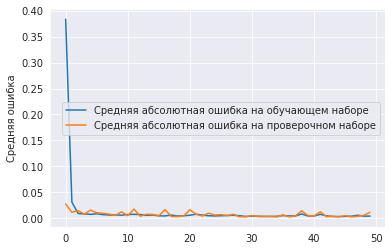

In [ ]:
#@title Выведем графики ошибки

plt.plot(history.history['loss'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

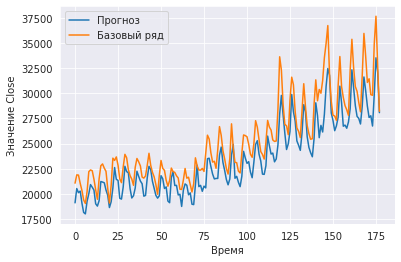

In [ ]:
#@title Прогнозируем данные текущей сетью

currModel = model
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler)
showPredict(0, 400, 0, predVal, yValUnscaled)

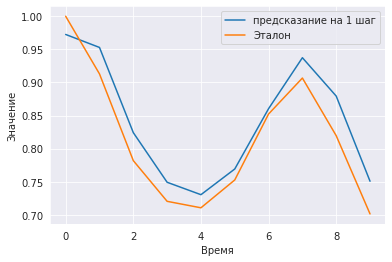

In [ ]:
#@title Отображаем корреляцию

autoCorr([0], 10, predVal, yValUnscaled)

# Конец